# Import

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import bz2
import urllib
import seaborn as sns
from datetime import datetime, date

data_folder = 'data/'

In [3]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores('test: The food was great!')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/theopatron/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.477, 'pos': 0.523, 'compound': 0.6588}

# Creation of extended files

### FOR THE TIMELINE
keep quotation mentionning guns 

### FOR THE ANALYSIS
keep quotation mentionning guns <br/>
keep only those that have a speaker <br/>
keep american speakers <br/>
add colums corresponding to characteristics of speaker <br/>

In [4]:
lexical_field = ['gun','firearm','mass shooting','2nd Amendment','homicide','gun shot','armed robbery','rifles','Second Amendment','Columbine', 'gun control']

speakers = pd.read_parquet(data_folder + 'speaker_attributes.parquet')
label = pd.read_csv(data_folder + 'wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [4]:
path_to_file = data_folder + 'quotes-2017.json.bz2' 
path_to_out = data_folder + 'quotes-2017-extended-3.json.bz2'

iter = 0
nb_occ = 0

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample

            iter += 1
            if instance['numOccurrences'] is not None:
                nb_occ += instance['numOccurrences']

            if (iter % 100000 == 0):
                print('nombre de citations lus: {}'.format(iter))

            if any(substring.lower() in instance['quotation'].lower() for substring in lexical_field) and instance['qids'] != []: #We keep only quotation containing words of the lexical field and where there is a speaker
                speaker = speakers.loc[speakers['id'] == instance['qids'][0]].squeeze()

                #We add nationality
                if speaker.nationality is not None:
                    instance['nationality'] = []
                    for i in speaker['nationality']:
                        nat = label.loc[i]['Label']
                        instance['nationality'].append(nat)
                else:
                    instance['nationality'] = None
                    
                #We add the gender
                if speaker.gender is not None:
                    instance['gender'] = []
                    for i in speaker['gender']:
                        gend = label.loc[i]['Label']
                        instance['gender'].append(gend)
                else:
                    instance['gender'] = None

                #We add the occupations
                if speaker.occupation is not None:
                    instance['occupation'] = []
                    for i in speaker['occupation']:
                        occ = label.loc[i]['Label']
                        instance['occupation'].append(occ)
                else:
                    instance['occupation'] = None

                #We add the date of birth
                try:
                    born = datetime.strptime(speaker.date_of_birth[0][1:11], "%Y-%m-%d").date()
                    today = date.today()
                    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
                except:
                    age = None
                instance['age'] = age

                #We add the ethnic group
                if speaker.ethnic_group is not None:
                    instance['ethnic_group'] = []
                    for i in speaker['ethnic_group']:
                        ethnic = label.loc[i]['Label']
                        instance['ethnic_group'].append(ethnic)
                else:
                    instance['ethnic_group'] = None

                #We add the party
                if speaker.party is not None:
                    instance['party'] = []
                    for i in speaker['party']:
                        part = label.loc[i]['Label']
                        instance['party'].append(part)
                else:
                    instance['party'] = None

                #We add the religion
                if speaker.religion is not None:
                    instance['religion'] = []
                    for i in speaker['religion']:
                        relig = label.loc[i]['Label']
                        instance['religion'].append(relig)
                else:
                    instance['religion'] = None

                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

                # to test
                # if iter > 10000:
                #     break

print('iter = {i}'.format(i = iter))
print('nb_occ = {n}'.format(n = nb_occ))

nombre de citations lus: 100000
nombre de citations lus: 200000
nombre de citations lus: 300000
nombre de citations lus: 400000
nombre de citations lus: 500000
nombre de citations lus: 600000
nombre de citations lus: 700000
nombre de citations lus: 800000
nombre de citations lus: 900000
nombre de citations lus: 1000000
nombre de citations lus: 1100000
nombre de citations lus: 1200000
nombre de citations lus: 1300000
nombre de citations lus: 1400000
nombre de citations lus: 1500000
nombre de citations lus: 1600000
nombre de citations lus: 1700000
nombre de citations lus: 1800000
nombre de citations lus: 1900000
nombre de citations lus: 2000000
nombre de citations lus: 2100000
nombre de citations lus: 2200000
nombre de citations lus: 2300000
nombre de citations lus: 2400000
nombre de citations lus: 2500000
nombre de citations lus: 2600000
nombre de citations lus: 2700000
nombre de citations lus: 2800000
nombre de citations lus: 2900000
nombre de citations lus: 3000000
nombre de citations

# Analysis

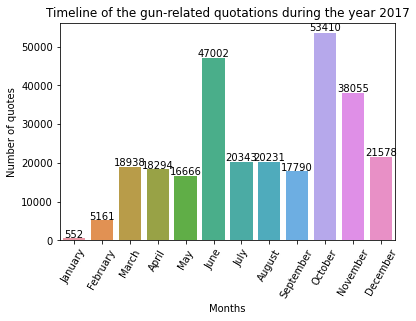

In [15]:
# Useful functions for the following plots

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

def process_chunk(chunk):
    df_temp = chunk.loc[chunk.index.repeat(chunk.numOccurrences)]
    ax = sns.countplot(x = df_temp.date.dt.month, data = df_temp)
    # print(f'Processing chunk with {len(chunk.loc[chunk.index.repeat(chunk.numOccurrences)])} rows')
    sns.set_color_codes("colorblind")
    ax.set_xlabel('Months')
    ax.set_ylabel('Number of quotes')
    ax.set_title('Timeline of the gun-related quotations during the year 2017')
    ax.set_xticklabels(labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    plt.xticks(rotation=60)
    show_values(ax)
    plt.show()

with pd.read_json(data_folder + 'quotes-2017-extended-3.json.bz2', lines=True, compression='bz2', chunksize=100000) as df_reader:
    for chunk in df_reader:
        process_chunk(chunk)
        